# LTU-ILI: GW inference example
### Author:
  - [@CompiledAtBirth](https://github.com/CompiledAtBirth) (Nicolas Chartier)


## Summary

- Work for the ILI group within [Simons Collaboration on Learning the Universe](https://www.learning-the-universe.org).
- Test on GW inference with multiround SNPE (or single round)

#O) Necessary installs and imports


# 0) Setup

### 0-1) If ltu-ili installed, start running below

In [1]:
!pip list | grep ltu
print("#######################")
!pip show torch
print("#######################")
!python --version
print("#######################")

import os
# ignore warnings for readability
import warnings
warnings.filterwarnings('ignore')
import time

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
import torch.nn as nn
import sbi

import ili
from ili.dataloaders import NumpyLoader, SBISimulator
from ili.inference.runner_sbi import SBIRunner, SBIRunnerSequential
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior
from ili.embedding import FCN

# PYCBC and LAL imports
import lal as _lal # _lal.LIGOTimeGPS
from pycbc.detector import Detector, get_available_detectors
from pycbc.waveform import generator, get_fd_waveform_from_td, get_td_waveform_from_fd, td_approximants, fd_approximants, get_td_waveform, get_fd_waveform
import pycbc.psd as psd
#from pycbc.noise import noise_from_psd
import pycbc.noise as pynoise
from pycbc.types import FrequencySeries, TimeSeries, complex_same_precision_as, real_same_precision_as, Array
from pycbc.filter import matchedfilter, sigmasq, make_frequency_series, highpass_fir, lowpass_fir, get_cutoff_indices
from pycbc.waveform.utils import apply_fd_time_shift, taper_timeseries, \
                                 ceilpow2

# If windowing
from scipy.signal import tukey

from scipy.interpolate import interp1d

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

# Needed for SBISimulator instance (as of now)
sims_dir  = "./sims"
if not os.path.exists(sims_dir):
  os.mkdir(sims_dir)

ltu-ili                       0.0.0               /home/chartier/Documents/LTU_ILI/Development/GW_EX/ltu-ili
#######################
Name: torch
Version: 1.12.0
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /home/chartier/Modules/miniconda3/envs/ili-sbi-dev/lib/python3.10/site-packages
Requires: typing-extensions
Required-by: nflows, pyknos, pyro-ppl, sbi
#######################
Python 3.10.13
#######################
Device: cpu


In [2]:
#PosteriorCoverage?
#SBIRunnerSequential?
sbi.inference.prepare_for_sbi?

Signature: sbi.inference.prepare_for_sbi(simulator: Callable, prior) -> Tuple[Callable, torch.distributions.distribution.Distribution]
Docstring:
Prepare simulator and prior for usage in sbi.

NOTE: This is a wrapper around `process_prior` and `process_simulator` which can be
used in isolation as well.

Attempts to meet the following requirements by reshaping and type-casting:

- the simulator function receives as input and returns a Tensor.<br/>
- the simulator can simulate batches of parameters and return batches of data.<br/>
- the prior does not produce batches and samples and evaluates to Tensor.<br/>
- the output shape is a `torch.Size((1,N))` (i.e, has a leading batch dimension 1).

If this is not possible, a suitable exception will be raised.

Args:
    simulator: Simulator as provided by the user.
    prior: Prior as provided by the user.

Returns:
    Tuple (simulator, prior) checked and matching the requirements of sbi.
File:      ~/Modules/miniconda3/envs/ili-sbi-dev/lib/py

In [3]:
def detector_psd_from_wf(my_series, f_low, psd_string= "aLIGOZeroDetHighPower"):
    '''
    Returns PSD with right shape given time or frequency series
    Default analytical computation is aLIGOZeroDetHighPower
    '''
    if isinstance(my_series, TimeSeries):

        P = my_series.sample_times.shape[0]
        delta_f = 1.0/my_series.duration # actually TimeSeries  instances also have a delta_f attribut
        Nfft = int(np.floor(P/2) + 1) # careful from real TD series, we divide the samples by 2 to get actual Nfft

    elif isinstance(my_series, FrequencySeries):

        Nfft = my_series.sample_frequencies.shape[0]
        delta_f = my_series.delta_f

    else:
        raise ValueError("mySeries argument must be a TimeSeries or FrequencySeries instance")

    return psd.from_string(psd_string, Nfft, delta_f, f_low)

# Actual way to do it according to pycbc documentation example
# Argumetns are TimeSeries of FrequencySeries instances
def resize_series(series1, series2):
    tlen = max(len(series1), len(series2))
    series1.resize(tlen)
    series2.resize(tlen)

def resizeSeries_list(series_list):
    max_len = max([len(s) for s in series_list])
    for s in series_list:
        s.resize(max_len)


## 0-2) Functions for forward model

In [4]:
def time_shift_fd(freq_series, t_shift):
  '''
  I cook my own function
  '''
  dt = float(t_shift - freq_series.start_time)
  freqs = freq_series.sample_frequencies.numpy()
  shift_arr =  np.array(np.exp(-2j*np.pi*(dt)*freqs), dtype=complex_same_precision_as(freq_series))

  return FrequencySeries(shift_arr*freq_series.data, delta_f = freq_series.delta_f)

def waveform_polarizations_fd(approximant, params_dict):

    if "delta_f" in params_dict:
        hp, hc = get_fd_waveform(approximant=approximant, **params_dict)
    else:
        raise ValueError("You must have either delta_t or delta_f in the dictionary")

    return hp, hc

def detector_frame_strain(hp, hc, detectors, det_params, verbose = False):

  '''
  detectors = List[str], for detector names
  domains = [bool_time, bool_freq],determines if we use data in time domain, frequency domain or both
  epoch : {float, lal.LIGOTimeGPS
          The epoch start time to set the waveform to. A time shift = tc - epoch is
          applied to waveforms before returning.
  tc: The GPS time of coalescence (should be geocentric time)
  '''

  h = {}
  detectors = {det: Detector(det) for det in detectors}
  hp.start_time = hc.start_time = det_params["start_time"]

  if isinstance(hp, FrequencySeries) and isinstance(hc, FrequencySeries):
# 17/01/2023 : astropy breaks to estimate antenna patterns (under the hood of pycbc)
      for detname, det in detectors.items():
        # apply detector response function
        fp, fc = det.antenna_pattern(det_params['ra'], det_params['dec'], det_params['polarization'],det_params['tc'])
        h_det = fp*hp + fc*hc
        #h_det = hp + hc

        # apply the time shift
        dt = det_params["tc"]+ det.time_delay_from_earth_center(det_params['ra'],det_params['dec'],det_params['tc'])
        #dt = det_params["tc"]
        if verbose:
          print("Time shift will be %.5f s"%(dt - h_det.start_time))
        h_det = time_shift_fd(h_det, dt) # my function, I understand what is happening
        #h_det = apply_fd_time_shift(h_det,dt)
        h[detname] = h_det

  else:
      raise ValueError("You must provide a FrequencySeries instance")

  return h

def inject_into_noise_fd(projected_signal, my_psd, fmin, fmax, tol = 1e-7):
  '''
  my_psd: FrequencySeries instance
  noise_timeseries: a TimeSeries instance corresponding to a random noise draw
  '''

  # Sanity check for delta_f
  df = projected_signal.delta_f
  if abs(my_psd.delta_f - df) > tol:
    raise Exception(f"Signal dd = {projected_signal.delta_f} does not "f"match psd df {my_psd.delta_f}")

  # Cutoff with fmin and fn = Nyquist frequency
  Nfft = len(projected_signal)
  N = (Nfft-1) * 2
  k_min, k_max = get_cutoff_indices(fmin, fmax, df,N)
  s = projected_signal.data[k_min:k_max]
  f = projected_signal.sample_frequencies[k_min:k_max]

  # Generate noise realization (straightforward in freq. domain)
  noise = np.random.randn(len(s)) + 1j * np.random.randn(len(s))

  # set DC and Nyquist = 0
  noise[0] = 0.

  # no Nyquist frequency when N=odd
  if np.mod(Nfft, 2) == 0:
      noise[-1] = 0.

  factor =  1./np.sqrt(4.0*df) # as in BilBy, check theory behind it!
  noise *= np.sqrt(my_psd.data[k_min:k_max])* 1./np.sqrt(4.0*df)

  return f, s, noise


## 0-3) Observation $x_0$, example of full forward model

In [5]:
# Uncomment below to get the list of available time domain or freq. domain waveforms
# print(td_approximants())
# print(fd_approximants())

In [6]:
# Time and duration parameters
tc = 1126259462.420 # time of coalescence in seconds
noise_duration = 4. # in seconds, and the inverse fixes delta_f

# We place the coalescence time at the midlle of the waveform in time domain.
my_epoch = tc - noise_duration/2. # starting time of the waveform

#approximant = "SEOBNRv4T" # time-domain
approximant = "IMRPhenomPv2" # frequency domain

# Parametrization for masses
q = 1.15625
M = 69. # in solar masses

mass1 = (q * M)/(q + 1.0)
mass2 = M/(q + 1.0)
ra = 2.2
dec = -1.25

# NOTE: Inclination runs from 0 to pi, with poles at 0 and pi
#       coa_phase runs from 0 to 2 pi.
inclination = 2.5 # in rad

coa_phase = 1.5 # in rad
polarization = 1.75
distance = 400. # in Mpc/h
f_ref = 14. # in Hz
f_lower = 14.

# Variable parameters for infence
inference_params = {"distance": distance,
             "mass1": mass1,
             "mass2": mass2}

d_theta = len(inference_params)
theta_obs = np.array([inference_params[entry] for entry in inference_params.keys()])
ss = ','.join(["{}".format(th) for th in theta_obs])
print(r"$\theta_0=%s$"%ss)


cbc_params = {"spin1z": 0.,
              "spin2z": 0.,
             "inclination": inclination, # inclination angle
             "coa_phase": coa_phase,
             "f_lower": f_lower,
             "f_ref": f_ref}

det_params = {"ra": ra,
              "dec": dec,
              "polarization":polarization,
              "start_time":my_epoch,
              "tc":tc
             }

Fs = 1024. # in Hz
Fn = 0.5*Fs # Nyquist-Shannon frequency
delta_t = 1./Fs
delta_f = 1./noise_duration # DFT property
cbc_params["delta_f"] = delta_f
N_time = int(Fs/delta_f)
Ndft = int(N_time/2)+1

# Which detector(s) do you want to study?
my_detectors = ["H1", "L1"]

obs_params = cbc_params.copy()

# For summary size
# fmin_sim must be higher than f_low_psd and lower freq. of approximant computation
fmin_sim = 20.
# Since delta_f is fixed by the duration in time domain, setting frequency bounds should
# give a fixed summary size after injection.
fmax_sim = 512. # should be lower or equal to the Nyquist frequency

$\theta_0=400.0,37.0,32.0$


In [7]:
# To have slightly faster computations, we compute a high resolution PSD and then passed
# to the simulator function
psd_str = "aLIGOZeroDetHighPower"
f_low_psd = 15. # in Hz
f_high_psd = Fn

### Below is just to double check the waveform and projection operations

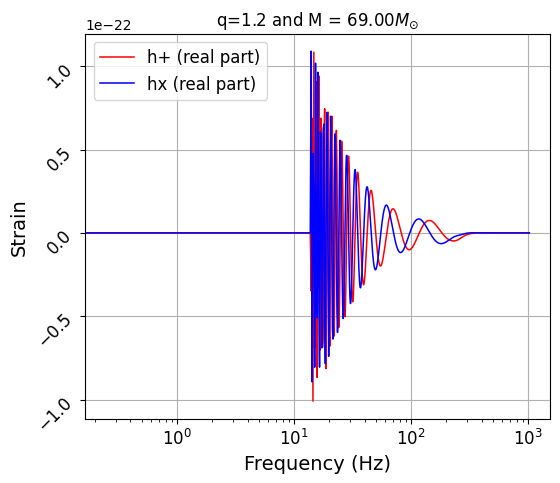

In [8]:
obs_params["mass1"] = mass1
obs_params["mass2"] = mass2
obs_params["distance"] = distance

# First operation: wavefrom approximant in radiation frame
hp, hc = waveform_polarizations_fd(approximant, obs_params)
indsum = np.where((hp.sample_frequencies>=fmin_sim)&(hp.sample_frequencies<=fmax_sim))


# Ensure at this point the waveforms have frequencies up to fmax_sim to avoid errors with get_cutoff_indices later
fmw = np.max(hp.sample_frequencies.numpy())
if fmw < fmax_sim:
  print("fmax sim pb detected")
  ds = int((fmax_sim - fmw)/delta_f) + 1
  hptemp = np.zeros((len(hp)+ds,))
  hctemp = np.zeros((len(hp)+ds,))
  hptemp[:len(hp)] = hp.data
  hctemp[:len(hp)] = hc.data
  hp = FrequencySeries(hptemp, delta_f = delta_f)
  hc = FrequencySeries(hctemp, delta_f = delta_f)

# Example Figure
plt.figure(figsize =(6,5))
plt.plot(hp.sample_frequencies, hp.data.real, label = "h+ (real part)", color = "red", linewidth = 1.1)
plt.plot(hc.sample_frequencies, hc.data.real, label = "hx (real part)", color = "blue", linewidth = 1.1)
plt.legend(fontsize = 12, loc = "upper left")
plt.xlabel("Frequency (Hz)", fontsize = 14)
plt.xscale("log")
plt.ylabel("Strain", fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12, rotation = 45)
plt.title("q=%.1f and M = %.2f"%(q,M) +"$M_{\odot}$", loc = "center")
plt.grid()

## PB ASTROPY TO ASSESS

In [ ]:
# Second operation: project onto detectors
h = detector_frame_strain(hp, hc, my_detectors, det_params, verbose = False)
%matplotlib inline

# Plot the strains for illustration
ht1 = h[my_detectors[0]]
ht2 = h[my_detectors[1]]

# Check consistency of dimensions
print(len(ht1.sample_frequencies[indsum]))
print(int((fmax_sim-fmin_sim)/delta_f)+1)

plt.figure(figsize =(6,5))
plt.plot(ht1.sample_frequencies, ht1.data, label = "Projection on %s"%my_detectors[0], color = "red", linewidth = 1.1)
#plt.plot(ht2.sample_frequencies, ht2.data, label = "Projection on %s"%my_detectors[1], color = "blue", linewidth = 1.1)
plt.legend(fontsize = 12, loc = "upper left")
plt.xlabel("Frequency (Hz)", fontsize = 14)
plt.xscale("log")
plt.ylabel("Projected Strain", fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12, rotation = 45)
plt.grid()

### Notes about summary size
- we cannot know in advance the size of the returned FrequencySeries, so we must crop the later in the simulator function
- given the typical size of the summary ($\sim 1000 - 10000$), an embedding net may constitute a good option for density estimation.

3936
20.0
511.75


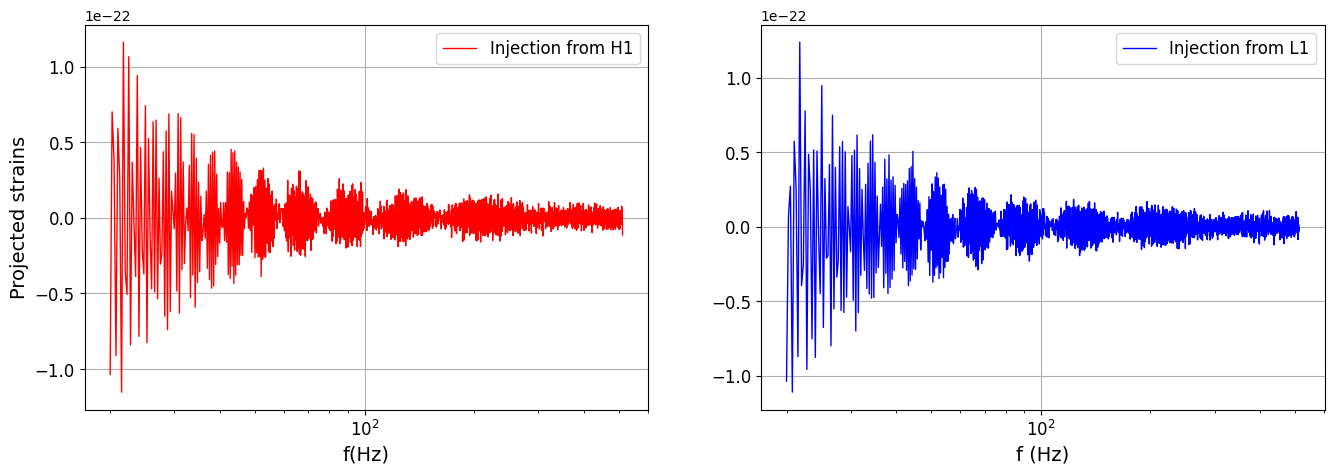

In [11]:
# Rearange into an array and add noise for each detector
total_dim = sum([len(hd) for hd in h])
x0 = np.array([])

# We fix the seed to generate fake observation
seeds = [30, 33]
si = 0
for ifo in my_detectors:

  l = len(h[ifo])

  Nfftd = len(h[ifo])
  Nt = (Nfftd -1)*2
  # Use delta_f = Fs/Nt to get fmax (Nyquist-Shannon)
  #fmax = 0.5 * h[ifo].delta_f*Nt
  seed = seeds[si] ; si +=1
  np.random.seed(seed)
  psd_ifo = psd.from_string(psd_str, Nfftd, delta_f = delta_f, low_freq_cutoff = f_low_psd)
  f,s,n = inject_into_noise_fd(h[ifo], psd_ifo, fmin_sim, fmax_sim, tol = 1e-7)
  x0 = np.concatenate((x0,s+n))

# Having dim_x fixed and consistent is important!
dim_x = len(x0)
print(dim_x)
print(np.min(f.numpy()))
print(np.max(f.numpy()))
x_0_file = "x0_observation.npy"
np.save(sims_dir + "/" + x_0_file, x0)

lh = int(len(x0)/2)
x1 = x0[:lh]
x2 = x0[lh:]

fig,ax = plt.subplots(1,2,figsize=(16,5))
ax[1].plot(f,x2, color = "blue", label = "Injection from %s"%my_detectors[1], linewidth = 1.0)
ax[1].set_xscale('log')
ax[1].grid()
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].set_xlabel("f (Hz)", fontsize = 14)
ax[1].legend(fontsize = 12, loc = "best")

ax[0].plot(f, x1, color = "red", label = "Injection from %s"%my_detectors[0], linewidth = 1.0)
ax[0].grid()
ax[0].set_xscale("log")
ax[0].set_ylabel("Projected strains", fontsize = 14)
ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[0].set_xlabel("f(Hz)", fontsize = 14)
ax[0].legend(fontsize = 12, loc = "best")

In [12]:
def gw_simulator(params):

  if isinstance(params, torch.Tensor):
    params = params.cpu().numpy().flatten()

  # Waveform in source frame
  obs_params["mass1"] = params[1]
  obs_params["mass2"] = params[2]
  obs_params["distance"] = params[0]
  hp, hc = waveform_polarizations_fd(approximant, obs_params)

  # Ensure at this point the waveforms have frequencies up to fmax_sim to avoid errors with get_cutoff_indices later
  fmw = np.max(hp.sample_frequencies.numpy())
  if fmw < fmax_sim:
    print("fmax sim pb detected")
    ds = int((fmax_sim - fmw)/delta_f) + 1
    hptemp = np.zeros((len(hp)+ds,))
    hctemp = np.zeros((len(hp)+ds,))
    hptemp[:len(hp)] = hp.data
    hctemp[:len(hp)] = hc.data
    hp = FrequencySeries(hptemp, delta_f = delta_f)
    hc = FrequencySeries(hctemp, delta_f = delta_f)

  # Waveform (or "strain") projection in detector frame
  # There will be as many strains as detectors in the analysis
  h_proj = detector_frame_strain(hp, hc, my_detectors, det_params, verbose = False)

  # Rearange into an array and add noise for each detector
  total_dim = sum([len(hd) for hd in h_proj])
  x = np.array([])

  for ifo in my_detectors:

    l = len(h_proj[ifo])

    Nfftd = len(h_proj[ifo])
    Nt = (Nfftd -1)*2
    psd_ifo = psd.from_string(psd_str, Nfftd, delta_f = delta_f, low_freq_cutoff = f_low_psd)
    f,s,n = inject_into_noise_fd(h_proj[ifo], psd_ifo, fmin_sim, fmax_sim, tol = 1e-7)
    x = np.concatenate((x,s+n))

  #return x
  # it seems that SBIRunnerSequential, as of 16/01/2024, throws error if the
  # simulator function returns a numpy.ndarray instance as in the tutorial.ipynb
  return torch.from_numpy(x).to(dtype = torch.float32, device = device)


In [13]:
# Test the simulator function is running
xtest = gw_simulator([200,30,40])
print(xtest.shape[0])
print(dim_x)

3936
3936


# 1) LTU-ILI, run inference

## 1-1) Instantiate LOADER

In [14]:
#SBISimulator?
n_sims = 20 # number of simulations of first round
print(sims_dir)

./sims


In [34]:
# define a prior
prior = ili.utils.Uniform(low=[200, 35., 35.], high=[1000.0,80., 80.], device=device)

#my_simulator = gw_simulator
my_simulator, my_prior = sbi.inference.prepare_for_sbi(gw_simulator, prior)
my_loader = SBISimulator(in_dir = sims_dir, xobs_file = x_0_file,
                         num_simulations = n_sims, simulator = my_simulator)

In [35]:
x0test = np.load(sims_dir + "/" + x_0_file)
print(x0test.shape)

(3936,)


### Parametrize embedding network

In [36]:
activation = "SiLU"
n_hidden = [100, 100, 100]
n_summary = 100
my_embedding = FCN(n_data = dim_x, n_hidden = n_hidden, act_fn = activation)

Prior values for masses similar as in [Green et. al, 2020](https://arxiv.org/pdf/2002.07656.pdf) for this example (section III-A)

In [37]:
# define an inference class (here, we are doing amortized posterior inference)
inference_class = sbi.inference.SNPE

# Optional signatures (not used, for illustration here)
#signatures = ["maf_test", "mdn_test"]
signatures = ["maf_test"]

# For more details with eg MAF, check the function build_maf in sbi/sbi/neural_nets/flow.py
type_de = "maf" # Masked Autoregressive Flows
nHiddenMAF = 80 # default is 50
numT = 5 # number of stacked MADEs in the MAF, default is 5 if not specified
dropoutMAF = 0.2 # the high-level sbi interface set this to 0.0 by default
batchNorm = False# use_batch_norm = False by default in high-level sbi
activationType = torch.tanh # default of high-level sbi is torch.tanh for buld_maf

density_maf = sbi.utils.get_nn_models.posterior_nn(model = type_de, hidden_features = nHiddenMAF, num_transforms = numT,
                                           activation = activationType, dropout_probability = dropoutMAF, use_batch_norm = batchNorm)

nets = [density_maf]
# instantiate your neural networks to be used as an ensemble
# nets = [
#     sbi.utils.posterior_nn(model='maf', hidden_features=200, num_transforms=5)
# ]
my_val_fraction = 0.1
# define training arguments: also "epochs",
train_args = {
    'training_batch_size': 64,
    'learning_rate': 1e-3,
    "validation_fraction": my_val_fraction,
    'num_round':1,
}

# initialize the trainer
runner = SBIRunnerSequential(
    prior=my_prior,
    inference_class=inference_class,
    nets=nets,
    device=device,
    embedding_net= my_embedding,
    train_args=train_args,
    proposal=None,
    output_path=None,# no output path, so nothing will be saved to file
    signatures = signatures
)


- Pb1 : params passed to gw_simulator within the sbi backend of ltu_ili gives an instance torch.Size([1, d]) where d is the number of parameters to infer (as of 16/01/2024).
- Sol1 : handle this directly in the simulator function by treating the parameters as a tensor and then flattening the array.

- Pb2: For the SBI loader class, in the simulate function, calling .numpy() method would not work on x if it was a torch.Tensor on cuda device (right after simulate_in_batches was completed)
- Sol2: preventively call the .cpu() method on the x tensor in simulate function of SBISimulator.

- Pb3: in the SBIRunner class, _train_round function, the line using model.append_simulations - after "if ("NPE" in self.class_name) throws an error in snpe_base from sbi package. If p is the dimension of the summary vector and n the number of sims (in the batch), then the assertion says that n should be identical to n*p (in the example 20 sims * 3936 = 78720). So it seems that n sims times p summary elements is treated as n*p sims.
```
/content/ltu-ili/ili/inference/runner_sbi.py in _train_round(self, models, x, theta, proposal)
    243             # append simulations
    244             if ("NPE" in self.class_name):
--> 245                 model = model.append_simulations(theta, x, proposal=proposal)
    246             else:
    247                 model = model.append_simulations(theta, x)

/usr/local/lib/python3.10/dist-packages/sbi/inference/snpe/snpe_base.py in append_simulations(self, theta, x, proposal, exclude_invalid_x, data_device)
    147             data_device = self._device
    148
--> 149         theta, x = validate_theta_and_x(
    150             theta, x, data_device=data_device, training_device=self._device
    151         )

/usr/local/lib/python3.10/dist-packages/sbi/utils/user_input_checks.py in validate_theta_and_x(theta, x, data_device, training_device)
    698     assert isinstance(x, Tensor), "Simulator output must be a `torch.Tensor`."
    699
--> 700     assert theta.shape[0] == x.shape[0], (
    701         f"Number of parameter sets (={theta.shape[0]} must match the number of "
    702         f"simulation outputs (={x.shape[0]})"

AssertionError: Number of parameter sets (=20 must match the number of simulation outputs (=78720)
```

In [38]:
# train the model
posterior_ensemble, summaries = runner(loader=my_loader)

INFO:root:MODEL INFERENCE CLASS: SNPE_C
INFO:root:The first round of inference will simulate from the given proposal or prior.
Running 20 simulations.: 100%|████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 20.87it/s]
INFO:root:Running round 1 / 1
INFO:root:Training model 1 / 1.


shape of x from simulate in batches
torch.Size([20, 3936])
(0,) (20, 3936)
shape of x numpy
(20, 3936)
shape of x
torch.Size([20, 3936])
shape of theta
torch.Size([20, 3])
 Neural network successfully converged after 31 epochs.

INFO:root:It took 0.8819918632507324 seconds to train models.


In [ ]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

In [ ]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    backend='sbi', output_path=None, num_samples=1000,
    sample_method='direct', labels=[f'$\\theta_{i}$' for i in range(3)]
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs = x[ind], theta_obs=theta[ind],
    x=x, theta=theta
)
